In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler

# Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)


# Ensure consistent data types and handle future warnings
pd.set_option('future.no_silent_downcasting', True)

In [2]:
# Load the data
raw_data = pd.read_csv('data/orders_export_1/orders_export_1.csv')

/var/folders/g3/y_p33x890117kpv5vtkgrkkr0000gn/T/ipykernel_90874/2011532045.py:2: DtypeWarning: Columns (20,28,52,56,72) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('data/orders_export_1/orders_export_1.csv')


## Data cleaning

In [3]:
raw_data.rename(columns={'Name': 'OrderID'}, inplace=True)

In [4]:
# Clean time columns 
time_col = ['Paid at', 'Fulfilled at', 'Created at']
for col in time_col:
    raw_data[col] = pd.to_datetime(raw_data[col].astype(str).str.split('+', expand=True)[0])


# Get data from 2024 onwards
df = raw_data[raw_data['Created at'].dt.year >= 2024]

In [5]:
# raw_data[raw_data['OrderID']=='#5893']

In [6]:
print("Old orders filtered count:", raw_data.shape[0] - df.shape[0])
print("Remaining orders count:", df.shape[0])

Old orders filtered count: 1142
Remaining orders count: 15535


## Tags definitions

**Faire-Wholesale** - orders that come through Faire (a different marketplace where we sell to B2B instead of B2C. As the pricing is different, I would recommend excluding this customers from your analysis)

**ReSell** - post purchase app we used for a period of time (but now we're back to using Recovert only). Post purchase means that that they get shown a product as an upsell at a discounted rate after placing their order, i.e. on the thank you page or at checkout etc etc

**Etsy** - I would exclude any Etsy customer from your analysis so it's solely focused on Shopify customers

**Loox** - Is the review app we use. It sends emails to customers to remind them to leave a review and uses incentives such as discounts (I can't remember on the top of my mind when they do this, e.g. if it's when asking for photos/videos) and reminds them about referrals.

**Current: pre-order** - as customer made the payment but the order gets shipped out later. We did this when we were out of stock on something but we no longer do this anymore.

**Online Store** - It's basically website, should be included

Exclude following tags:
1. Faire-Wholesale
2. Esty

In [7]:
df = df.copy()  # Ensure it's a fresh copy, not a slice
df['ExcludeTag'] = df['Tags'].str.contains('Faire|Etsy', case=False, na=False)


/var/folders/g3/y_p33x890117kpv5vtkgrkkr0000gn/T/ipykernel_90874/3120402333.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='pastel')


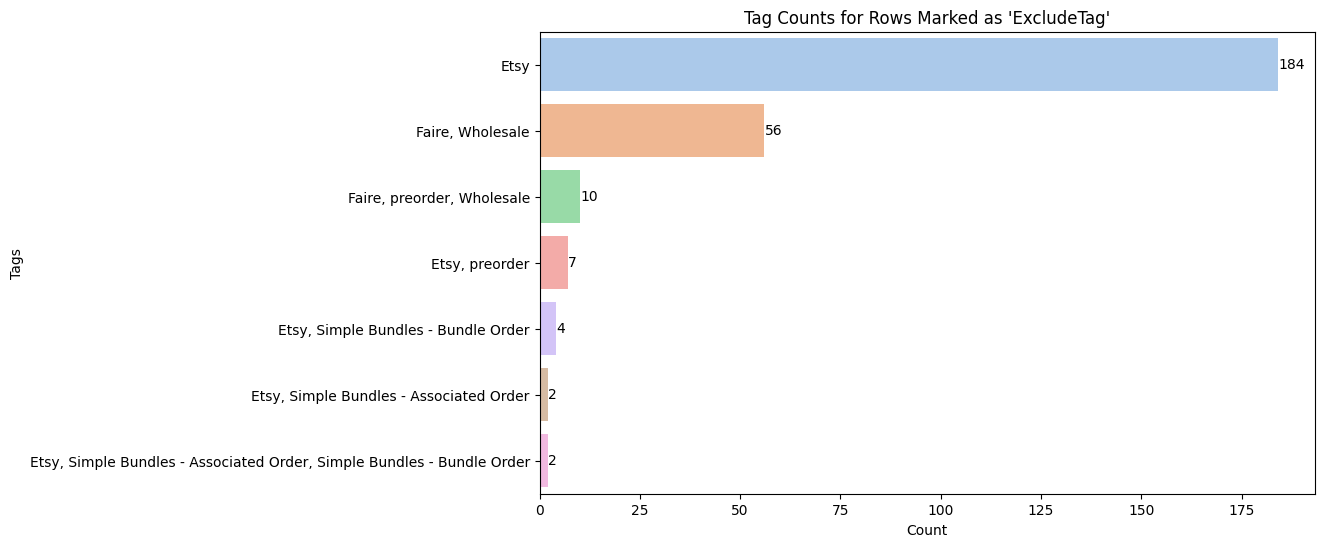

In [8]:
# Count the tags where 'ExcludeTag' is True
tag_counts = df[df['ExcludeTag'] == True]['Tags'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='pastel')

# Add annotations
for index, value in enumerate(tag_counts.values):
    plt.text(value + 0.1, index, str(value), va='center')

plt.title("Tag Counts for Rows Marked as 'ExcludeTag'")
plt.xlabel("Count")
plt.ylabel("Tags")
plt.show()

/var/folders/g3/y_p33x890117kpv5vtkgrkkr0000gn/T/ipykernel_90874/771157488.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='pastel')


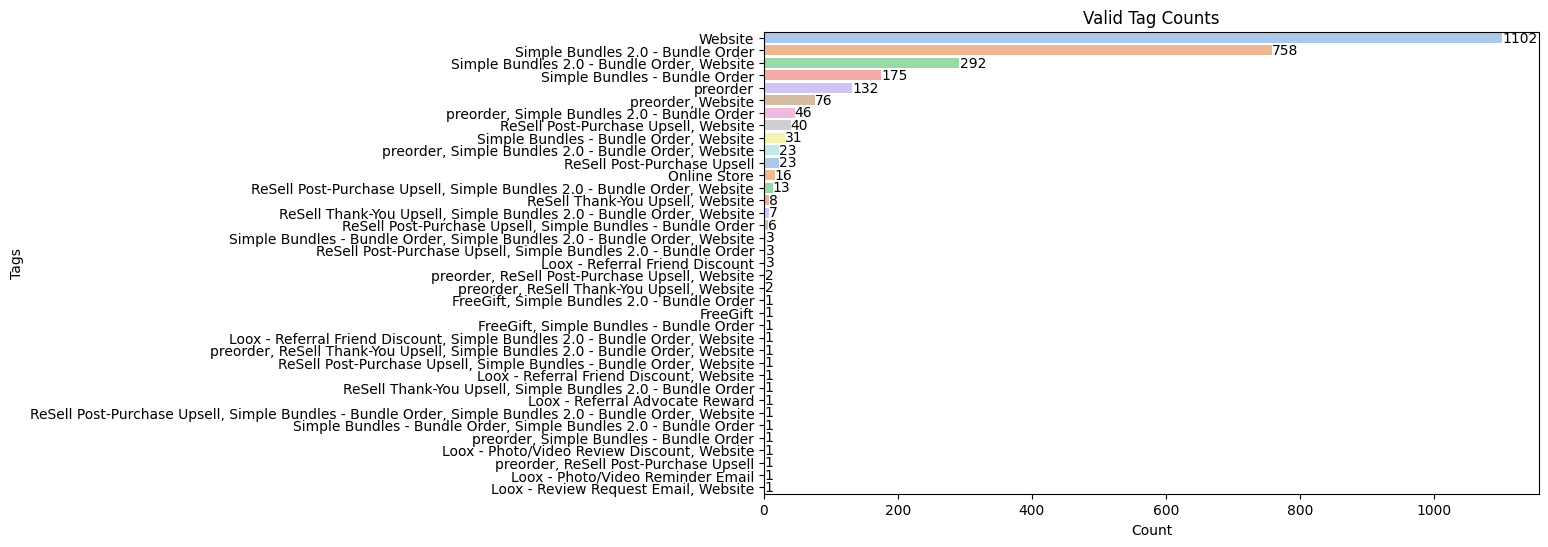

In [9]:
# Remaining valid tags
tag_counts = df[df['ExcludeTag'] == False]['Tags'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='pastel')

# Add annotations
for index, value in enumerate(tag_counts.values):
    plt.text(value + 0.1, index, str(value), va='center')

plt.title("Valid Tag Counts")
plt.xlabel("Count")
plt.ylabel("Tags")
plt.show()

In [10]:
# Exclude the tag
df = df[df['ExcludeTag'] == False]
print("Remaining orders count:", df['OrderID'].unique().shape[0])
print("Remaining products count:", df.shape[0])

Remaining orders count: 8023
Remaining products count: 15270


In [11]:
# Define conditions and corresponding values
conditions = [
    df['Tags'].str.contains('ReSell', case=False, na=False),
    df['Tags'].str.contains('Loox', case=False, na=False)
]
values = ['ReSell', 'Loox']

# Apply conditions and rename the column to 'Sales Channel'
df['Sales Channel'] = np.select(conditions, values, default='Normal')

In [12]:
df['Sales Channel'].value_counts()

Sales Channel
Normal    15152
ReSell      109
Loox          9
Name: count, dtype: int64

In [13]:
# Dealing with multiple products under one order
# Under one OrderID, there's only first row of the product that has the correct information, others all Null, # e.g. OrderID #9948
# Solution: Fill missing values under the same OrderID with the first row's non-null values
for col in df.columns:
    df[col] = df.groupby('OrderID')[col].transform(lambda x: x.ffill().bfill())


### Create Bundle column
- Check if tags column contains any tex of "Bundle" 

*Note*

if a bundle is bought as an another product in a same order, especially not the first product, we cannot tell if this product is under a bundle.

This is one of the assumptions in this analysis. E.g. ProductID: #5893

In [14]:
# Create the 'Bundle' column to classify bundle orders
df['Bundle'] = df['Tags'].apply(lambda tag: 'Yes' if 'bundle' in str(tag).lower() else 'No')

In [15]:
df['Bundle'].value_counts()

Bundle
No     10371
Yes     4899
Name: count, dtype: int64

In [16]:
df[df['OrderID']=='#9948']

,OrderID,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,Taxes,Total,Discount Code,Discount Amount,Shipping Method,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem compare at price,Lineitem sku,Lineitem requires shipping,Lineitem taxable,Lineitem fulfillment status,Billing Name,Billing Street,Billing Address1,Billing Address2,Billing Company,Billing City,Billing Zip,Billing Province,Billing Country,Billing Phone,Shipping Name,Shipping Street,Shipping Address1,Shipping Address2,Shipping Company,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Shipping Phone,Notes,Note Attributes,Cancelled at,Payment Method,Payment Reference,Refunded Amount,Vendor,Id,Tags,Risk Level,Source,Lineitem discount,Tax 1 Name,Tax 1 Value,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,Duties,Billing Province Name,Shipping Province Name,Payment ID,Payment Terms Name,Next Payment Due At,Payment References,ExcludeTag,Sales Channel,Bundle
2,#9948,gavdncl@gmail.com,paid,2025-03-25 06:25:25,fulfilled,2025-03-25 08:02:09,no,GBP,76.5,9.5,14.33,86.0,NaN,0.0,Next Day Delivery,2025-03-25 06:25:24,1,Buttery Croissant Candle - Glass candle (165g),25.5,0.0,CND-BUC-G,True,True,fulfilled,Gavin Dugdale,"Fairway, Newcastle Road",Fairway,Newcastle Road,NaN,Durham,DH1 4HZ,ENG,GB,NaN,Gavin Dugdale,"Fairway, Newcastle road",Fairway,Newcastle road,NaN,Crossgate Moor,DH1 4HZ,ENG,GB,NaN,NaN,Currency rate: 1\nMarket: gb,NaN,Shopify Payments,rdvX9FdB9NrtT886IRwflWvAk,0.0,wickguru,1.167224e+13,Simple Bundles 2.0 - Bundle Order,Low,web,0.0,GB VAT 20%,14.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rdvX9FdB9NrtT886IRwflWvAk,NaN,NaN,rdvX9FdB9NrtT886IRwflWvAk,False,Normal,Yes
3,#9948,gavdncl@gmail.com,paid,2025-03-25 06:25:25,fulfilled,2025-03-25 08:02:09,no,GBP,76.5,9.5,14.33,86.0,NaN,0.0,Next Day Delivery,2025-03-25 06:25:24,1,Pistachio Macaron Candle - Glass candle (165g),25.5,0.0,CND-PIM-G,True,True,fulfilled,Gavin Dugdale,"Fairway, Newcastle Road",Fairway,Newcastle Road,NaN,Durham,DH1 4HZ,ENG,GB,NaN,Gavin Dugdale,"Fairway, Newcastle road",Fairway,Newcastle road,NaN,Crossgate Moor,DH1 4HZ,ENG,GB,NaN,NaN,Currency rate: 1\nMarket: gb,NaN,Shopify Payments,rdvX9FdB9NrtT886IRwflWvAk,0.0,wickguru,1.167224e+13,Simple Bundles 2.0 - Bundle Order,Low,web,0.0,GB VAT 20%,14.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rdvX9FdB9NrtT886IRwflWvAk,NaN,NaN,rdvX9FdB9NrtT886IRwflWvAk,False,Normal,Yes
4,#9948,gavdncl@gmail.com,paid,2025-03-25 06:25:25,fulfilled,2025-03-25 08:02:09,no,GBP,76.5,9.5,14.33,86.0,NaN,0.0,Next Day Delivery,2025-03-25 06:25:24,1,Baked Cookies Candle - Glass candle (165g),25.5,0.0,CND-BAC-G,True,True,fulfilled,Gavin Dugdale,"Fairway, Newcastle Road",Fairway,Newcastle Road,NaN,Durham,DH1 4HZ,ENG,GB,NaN,Gavin Dugdale,"Fairway, Newcastle road",Fairway,Newcastle road,NaN,Crossgate Moor,DH1 4HZ,ENG,GB,NaN,NaN,Currency rate: 1\nMarket: gb,NaN,Shopify Payments,rdvX9FdB9NrtT886IRwflWvAk,0.0,wickguru,1.167224e+13,Simple Bundles 2.0 - Bundle Order,Low,web,0.0,GB VAT 20%,14.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rdvX9FdB9NrtT886IRwflWvAk,NaN,NaN,rdvX9FdB9NrtT886IRwflWvAk,False,Normal,Yes


## Generate CustomerID
- Create a unique CustomerID based on Email, sorted by 'Created at' ascending order
- Earlier customers will have lower CustomerID starting from 1

In [17]:
# Create a unique CustomerID based on Email, sorted by 'Created at' ascending order
# Earlier customers will have lower CustomerID starting from 1
if 'Email' in df.columns and 'Created at' in df.columns:
    df = df.sort_values(by='Created at').reset_index(drop=True)
    unique_emails = df['Email'].unique()
    email_to_id = {email: idx + 1 for idx, email in enumerate(unique_emails)}
    df['CustomerID'] = df['Email'].map(email_to_id)

print("Customer unique count to date: ", df['CustomerID'].max())

Customer unique count to date:  7325


/var/folders/g3/y_p33x890117kpv5vtkgrkkr0000gn/T/ipykernel_90874/375081095.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='pastel')


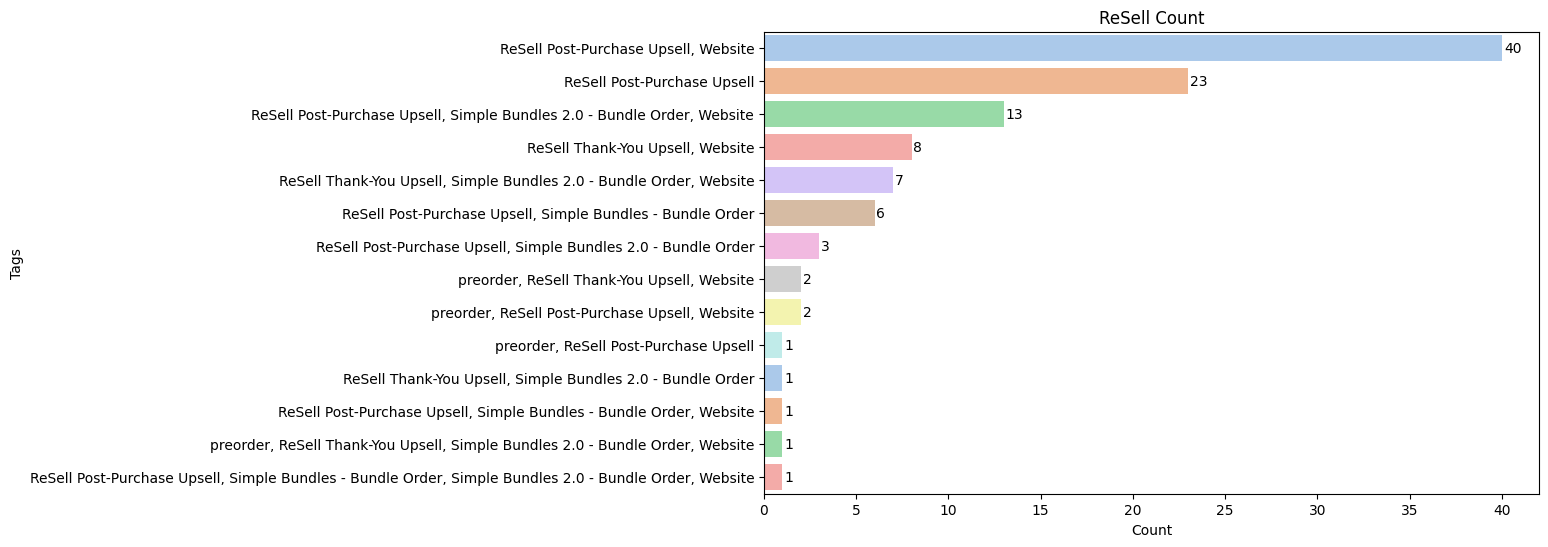

In [18]:
# Count the tags where 'ExcludeTag' is True
tag_counts = df[df['Sales Channel'] == 'ReSell']['Tags'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette='pastel')

# Add annotations
for index, value in enumerate(tag_counts.values):
    plt.text(value + 0.1, index, str(value), va='center')

plt.title("ReSell Count")
plt.xlabel("Count")
plt.ylabel("Tags")
plt.show()

In [19]:
# Basic statistics
print("\nDescriptive statistics:\n", df.describe())


Descriptive statistics:
                              Paid at                   Fulfilled at  \
count                          15017                          14931   
mean   2024-09-19 12:50:32.398082304  2024-09-24 22:10:27.731497984   
min              2024-01-01 14:25:04            2024-01-03 13:08:52   
25%              2024-07-09 16:37:31            2024-07-15 15:13:33   
50%              2024-10-25 12:13:12            2024-11-01 15:45:30   
75%              2024-11-30 22:02:38     2024-12-11 17:32:14.500000   
max              2025-03-25 09:25:20            2025-03-25 08:02:09   
std                              NaN                            NaN   

           Subtotal      Shipping         Taxes         Total  \
count  15046.000000  15046.000000  15046.000000  15046.000000   
mean      55.341514      2.643292      0.178663     57.984180   
min        0.000000      0.000000      0.000000      0.000000   
25%       30.000000      0.000000      0.000000     33.990000   
50%      

## Recurring Customer Definition
1. Purchase more than one order in the last 6 months
  - (More accurate timeframe should be defined by studying how often a customer comes back, for now this is good enough for version #1 for us to start)
2. If a customer purchase multiple orders in a day, it's consider one order, not recurring customer

In [20]:
df['Paid at date'] = df['Paid at'].dt.date

In [21]:
# Aggregate the data to per order level
# 1 orderID now corresponds to 1 row, sometimes it has multiple products under Lineitem quantity
# E.g. OrderID ##9936
agg_orders = df.groupby('OrderID').agg({'Email': 'max',
                           'CustomerID': 'max',
                           'Paid at': 'max',
                            'Fulfilled at': 'max',
                            'Created at': 'max',
                            'Cancelled at': 'max',
                            'Tags': 'max',
                            'Sales Channel': 'max',
                            'Bundle': 'max',
                            'Financial Status': 'max',
                            'Fulfillment Status': 'max',
                            'Lineitem quantity': 'sum',
                            'Discount Amount': 'mean',
                            'Total': 'mean',
                                        }).reset_index()

print("Total products count: ", agg_orders['Lineitem quantity'].sum())
print("Total orders count: ", agg_orders['OrderID'].shape[0])

Total products count:  16400
Total orders count:  8023


In [22]:
# Convert 'Created at' and 'Paid at' to datetime
agg_orders['Created at'] = pd.to_datetime(agg_orders['Created at'])
agg_orders['Paid at'] = pd.to_datetime(agg_orders['Paid at'])

# Define the date range (last 6 months)
last_6_months = agg_orders['Created at'].max() - pd.DateOffset(months=6)

# Filter data for the last 6 months
df_recent = agg_orders[agg_orders['Created at'] >= last_6_months].copy()

# Extract only the date (ignoring time)
df_recent['Order Date'] = df_recent['Created at'].dt.date

# Count the number of unique order dates per customer
customer_orders = df_recent.groupby('CustomerID')['Order Date'].nunique()

# Create a dictionary mapping CustomerID to Customer Type
customer_type_map = {}
for customer in df_recent['CustomerID'].unique():
    customer_paid_at = agg_orders.loc[agg_orders['CustomerID']
                                      == customer, 'Paid at']

    if customer_paid_at.isnull().all():
        customer_type_map[customer] = "Never pay"
    else:
        order_count = customer_orders.get(customer, 0)
        customer_type_map[customer] = "Recurring" if order_count > 1 else "One-time"

# Apply the mapping to a new column
agg_orders['Customer Type'] = agg_orders['CustomerID'].map(
    customer_type_map).fillna("One-time")


## Key point #1

Total Customer Unique Count: 7325

Total Order Unique Count: 8023

Total Product Purchased Unique Count: 16400

There's 7,101 One-Time Customer (96.9%), 185 Recurring Customer (2.5%) and 39 Never-pay Customer (0.5%)


In [23]:
print("Total Customer Unique Count:", len(agg_orders['CustomerID'].unique()))
print("Total Order Unique Count:", len(agg_orders['OrderID'].unique()))
print("Total Product Purchased Unique Count:", agg_orders['Lineitem quantity'].sum())

Total Customer Unique Count: 7325
Total Order Unique Count: 8023
Total Product Purchased Unique Count: 16400


In [24]:
# Count unique customers for each customer type
unique_customer_counts = agg_orders.groupby(
    'Customer Type')['CustomerID'].nunique().reset_index()
unique_customer_counts.columns = ['Customer Type', 'Unique Customers']

# Calculate percentages
total_customers = unique_customer_counts['Unique Customers'].sum()
unique_customer_counts['Percentage'] = (
    unique_customer_counts['Unique Customers'] / total_customers) * 100

# Create an interactive bar chart
fig = px.bar(unique_customer_counts,
             x='Customer Type',
             y='Unique Customers',
             text=unique_customer_counts.apply(
                 lambda row: f"{row['Unique Customers']} ({row['Percentage']:.1f}%)", axis=1),
             color='Customer Type',
             title='Unique Customer Distribution by Type',
             labels={'Unique Customers': 'Number of Unique Customers'},
             color_discrete_map={'Recurring': 'lightcoral', 'One-time': 'skyblue', 'Error: Missing Paid at': 'gray'})

# Adjust text position
fig.update_traces(textposition='outside')

# Move legend to the top middle
fig.update_layout(
    height=500,  # Increase chart height
    legend=dict(
    orientation="h", yanchor="bottom", y=1.1, xanchor="center", x=0.5,
    ))

# Show the interactive chart
fig.show()

#### Q1 - Is recurring customer purchased more bundle?
1. There's ~17% of one-time customer purchased with bundle and ~29% of recurring customer purchased bundle.

In [25]:
# import plotly.graph_objects as go

# # Split data for Yes and No bundles
# yes_data = unique_customer_counts[unique_customer_counts['Bundle'] == 'Yes']
# no_data = unique_customer_counts[unique_customer_counts['Bundle'] == 'No']

# # Create figure manually
# fig = go.Figure()

# # Add No Bundle trace
# fig.add_bar(
#     x=no_data['Customer Type'],
#     y=no_data['Unique Customers'],
#     name='No',
#     marker_color=color_map['No'],
#     text=no_data.apply(lambda row: f"{row['Unique Customers']} ({row['Percentage']}%)", axis=1),
#     textposition='outside',
#     textfont=dict(size=14)
# )

# # Add Yes Bundle trace
# fig.add_bar(
#     x=yes_data['Customer Type'],
#     y=yes_data['Unique Customers'],
#     name='Yes',
#     marker_color=color_map['Yes'],
#     text=yes_data.apply(lambda row: f"{row['Unique Customers']} ({row['Percentage']}%)", axis=1),
#     textposition='outside',
#     textfont=dict(size=14)
# )

# # Update layout
# fig.update_layout(
#     height=600,
#     barmode='stack',
#     title='Unique Customer Breakdown by Bundle Purchases',
#     xaxis_title='Customer Type',
#     yaxis_title='Number of Unique Customers',
#     legend_title='Bundle Purchase',
#     uniformtext_minsize=12,
#     uniformtext_mode='hide',
#     legend=dict(
#         orientation="h",
#         yanchor="bottom",
#         y=1.1,
#         xanchor="center",
#         x=0.5
#     )
# )

# fig.show()

#### Q2 - For returning customer and when they first purchased without bundle, what's the percentage of them purchased with bundle in the future?
1. 26.1% of customers who initially purchased without a bundle later bought a bundle.
2. This suggests that bundles may have some influence in retaining customers or encouraging repeat purchases.

In [26]:
# Filter only recurring customers
recurring_customers = agg_orders[agg_orders['Customer Type'] == 'Recurring']

# Identify first purchase for each recurring customer
first_purchases = recurring_customers.loc[recurring_customers.groupby('CustomerID')['Created at'].idxmin(), ['CustomerID', 'Bundle']]

# Identify customers whose first purchase was without a bundle
first_without_bundle = first_purchases[first_purchases['Bundle']== 'No']['CustomerID']

# Check if these customers later purchased with a bundle
later_purchases = recurring_customers[recurring_customers['CustomerID'].isin(first_without_bundle)]
purchased_bundle_later = later_purchases.groupby('CustomerID')['Bundle'].apply(lambda x: (x == 'Yes').any())

# Calculate the percentage
percentage_purchased_bundle = purchased_bundle_later.mean() * 100

print(
    f"Percentage of recurring customers who first purchased without a bundle and later bought one: {percentage_purchased_bundle:.1f}%")

Percentage of recurring customers who first purchased without a bundle and later bought one: 26.1%


#### Q3 - Recurring customer behaviour on bundle


In [27]:
recurring = agg_orders[agg_orders['Customer Type'] == 'Recurring'].copy()

In [28]:
recurring.shape
first_purchases.shape

(185, 2)

In [29]:
first_purchases = recurring.sort_values(by=['CustomerID', 'Paid at']).drop_duplicates('CustomerID', keep='first')

In [30]:
first_purchases['Bundle'].value_counts()

Bundle
No     153
Yes     32
Name: count, dtype: int64

In [31]:
first_purchases_no_bundle = first_purchases[first_purchases['Bundle']== 'No']['CustomerID'].unique().tolist()

In [32]:
agg_orders['First Purchase No Bundle'] = agg_orders['CustomerID'].isin(first_purchases_no_bundle)

In [33]:
agg_orders[agg_orders['First Purchase No Bundle'] == True].head()

,OrderID,Email,CustomerID,Paid at,Fulfilled at,Created at,Cancelled at,Tags,Sales Channel,Bundle,Financial Status,Fulfillment Status,Lineitem quantity,Discount Amount,Total,Customer Type,First Purchase No Bundle
144,#1896,essieirc@yahoo.com,137,2024-02-02 19:12:12,2024-02-03 12:48:54,2024-02-02 19:12:11,NaN,NaN,Normal,No,paid,fulfilled,2,4.97,44.73,Recurring,True
190,#1942,isabelmpdix@gmail.com,182,2024-02-09 17:31:50,2024-02-12 10:46:03,2024-02-09 17:31:49,NaN,NaN,Normal,No,paid,fulfilled,2,4.20,26.70,Recurring,True
341,#2093,ellibailey@googlemail.com,328,2024-03-04 12:17:18,2024-03-04 15:03:15,2024-03-04 12:17:17,NaN,NaN,Normal,No,paid,fulfilled,2,5.20,46.80,Recurring,True
417,#2169,essieirc@yahoo.com,137,2024-03-11 01:52:21,2024-03-11 11:25:52,2024-03-11 01:52:21,NaN,NaN,Normal,No,paid,fulfilled,2,7.77,44.03,Recurring,True
519,#2271,christie.genochio@gmail.com,499,2024-03-19 22:17:14,2024-03-20 11:39:15,2024-03-19 22:17:13,NaN,NaN,Normal,No,paid,fulfilled,2,8.03,72.27,Recurring,True


In [34]:
# Sort orders by CustomerID and Paid at
agg_orders = agg_orders.sort_values(by=['CustomerID', 'Paid at'])

# Identify the second purchase per customer
second_purchases = agg_orders.groupby('CustomerID').nth(1)  # nth(1) gets the second purchase

# Extract Bundle status for second purchases
second_purchases = second_purchases[['Bundle']].reset_index()

# Rename column for clarity
second_purchases.rename(columns={'Bundle': 'Second Purchase Bundle'}, inplace=True)

In [35]:
# agg_orders.to_csv('data/orders_export_1/agg_orders.csv', index=False)

In [36]:
## Order level data
df_order = df.copy()

In [37]:
df = recurring.copy()

# Convert 'Paid at' to datetime for proper sorting
df["Paid at"] = pd.to_datetime(df["Paid at"])

# Sort data by CustomerID and Paid at to track purchase sequences
df = df.sort_values(by=["CustomerID", "Paid at"])

# Assign purchase number per customer (1st, 2nd, etc.)
df["Purchase Number"] = df.groupby("CustomerID").cumcount() + 1

# Create a summary of purchase sequences per customer
purchase_summary = df.pivot(
    index="CustomerID", columns="Purchase Number", values="Bundle")

# Rename columns for clarity
purchase_summary.columns = [
    f"Purchase {col}" for col in purchase_summary.columns]

# Display transformed data
purchase_summary.head()

,Purchase 1,Purchase 2,Purchase 3,Purchase 4,Purchase 5,Purchase 6,Purchase 7,Purchase 8,Purchase 9,Purchase 10
CustomerID,,,,,,,,,,
137,No,No,Yes,Yes,No,Yes,NaN,NaN,NaN,NaN
182,No,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN
328,No,Yes,Yes,No,No,NaN,NaN,NaN,NaN,NaN
499,No,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN
655,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN


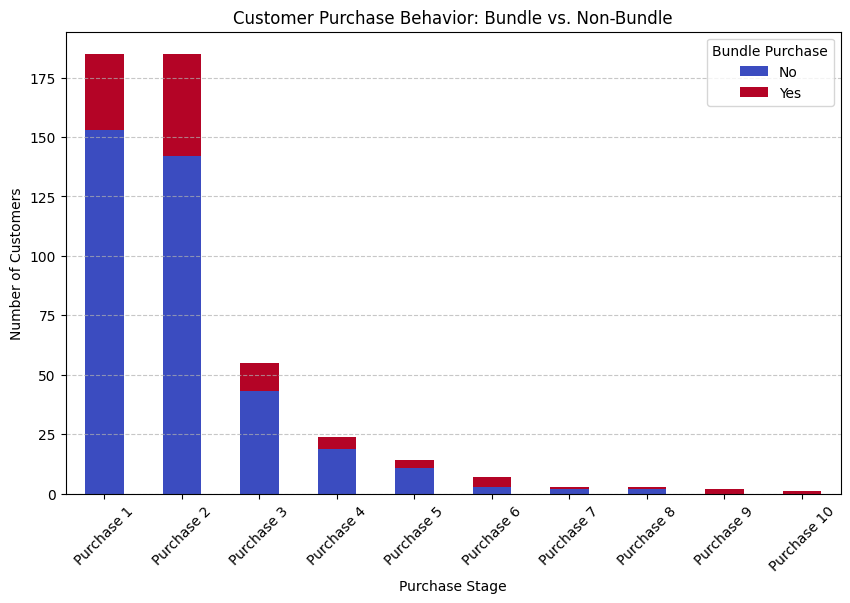

In [38]:
# Count occurrences of 'Yes' and 'No' for each purchase stage
bundle_counts = purchase_summary.apply(lambda x: x.value_counts(), axis=0).fillna(0)

# Plot stacked bar chart
bundle_counts.T.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="coolwarm")

plt.title("Customer Purchase Behavior: Bundle vs. Non-Bundle")
plt.xlabel("Purchase Stage")
plt.ylabel("Number of Customers")
plt.legend(title="Bundle Purchase", labels=["No", "Yes"])
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

**Interpretation**

1. 78.39% of customers who didn’t buy a bundle continued without a bundle, while 21.61% switched to a bundle.

2. 63.79% of customers who bought a bundle switched back to non-bundle, while 36.21% continued buying bundles.

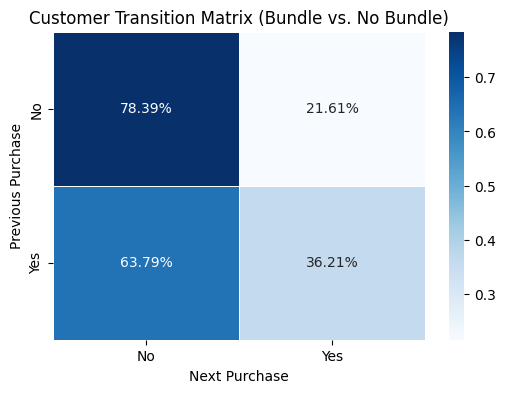

In [39]:
# Flatten transitions: extract pairs of (previous_purchase, next_purchase)
transitions = []
# From first to second, second to third, etc.
for col in range(1, purchase_summary.shape[1]):
    prev_col = f"Purchase {col}"
    next_col = f"Purchase {col + 1}"
    if prev_col in purchase_summary and next_col in purchase_summary:
        transitions += list(zip(purchase_summary[prev_col],
                            purchase_summary[next_col]))

# Convert to DataFrame and drop NaN values (customers who didn’t make a next purchase)
transition_df = pd.DataFrame(
    transitions, columns=["Previous", "Next"]).dropna()

# Compute transition matrix (count occurrences)
transition_matrix = pd.crosstab(
    transition_df["Previous"], transition_df["Next"], normalize="index")

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(transition_matrix, annot=True,
            cmap="Blues", fmt=".2%", linewidths=0.5)

# Labels and title
plt.title("Customer Transition Matrix (Bundle vs. No Bundle)")
plt.xlabel("Next Purchase")
plt.ylabel("Previous Purchase")

# Show plot
plt.show()

We also can see that among all the 185 recurring customer, majority of the purchases are <= 2 orders

There's 55 customer purchase more than 3 orders in recent 6 months and we should always engage with this customers. They can be defined as **Golden Customer**

In [40]:
print("More than 3 purchases: ", len(purchase_summary[~purchase_summary['Purchase 3'].isnull()].reset_index()['CustomerID'].unique()))
print("Less than 3 purchases: ", len(purchase_summary[purchase_summary['Purchase 3'].isnull()].reset_index()['CustomerID'].unique()))

More than 3 purchases:  55
Less than 3 purchases:  130


## Part A. Purchase Patterns & Recurrence Trends.

### 1: How many days/weeks/months does it take for a first-time customer to make a second purchase?

Here are the days by which specific percentages of Recurring customers make their second purchase:

20% repurchase within 17 days

50% repurchase within 37 days

80% repurchase within 84 days

In [41]:
df = recurring.copy()
# Preprocessing
df['Paid at'] = pd.to_datetime(df['Paid at'])
df = df.dropna(subset=['Paid at'])  # remove rows with missing 'Paid at'

# Sort by CustomerID and Paid at
df = df.sort_values(by=['CustomerID', 'Paid at'])

# Group by customer to calculate time difference between first and second purchase


def recurring_repurchase_timing(group):
    if len(group) < 2:
        return pd.Series()
    return pd.Series({
        "days_to_second": (group["Paid at"].iloc[1] - group["Paid at"].iloc[0]).days,
        "first_bundle": group["Bundle"].iloc[0],
        "first_discount": group["Discount Amount"].iloc[0]
    })


recurring_repurchase_details = df.groupby('CustomerID').apply(recurring_repurchase_timing).dropna()

# Percentage of customers repurchasing within 30, 60, 90 days
total_repeat_customers = len(recurring_repurchase_details)
within_30 = (recurring_repurchase_details['days_to_second']
             <= 30).sum() / total_repeat_customers * 100
within_60 = (recurring_repurchase_details['days_to_second']
             <= 60).sum() / total_repeat_customers * 100
within_90 = (recurring_repurchase_details['days_to_second']
             <= 90).sum() / total_repeat_customers * 100

/var/folders/g3/y_p33x890117kpv5vtkgrkkr0000gn/T/ipykernel_90874/2528730856.py:22: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



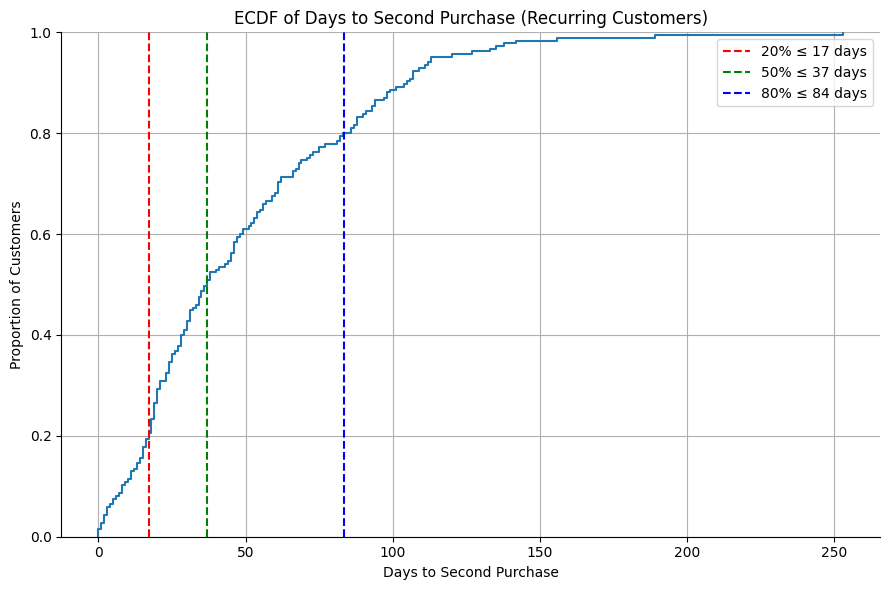

In [42]:
# Compute ECDF x-values at 20%, 50%, 80%
quantiles = recurring_repurchase_details["days_to_second"].quantile([0.2, 0.5, 0.8])
q20, q50, q80 = quantiles[0.2], quantiles[0.5], quantiles[0.8]

# Plot ECDF
sns.displot(
    recurring_repurchase_details,
    x="days_to_second",
    kind="ecdf",
    height=6,
    aspect=1.5
)

# Annotate quantiles
plt.axvline(q20, color='red', linestyle='--', label=f'20% ≤ {q20:.0f} days')
plt.axvline(q50, color='green', linestyle='--', label=f'50% ≤ {q50:.0f} days')
plt.axvline(q80, color='blue', linestyle='--', label=f'80% ≤ {q80:.0f} days')

plt.legend()
plt.title("ECDF of Days to Second Purchase (Recurring Customers)")
plt.xlabel("Days to Second Purchase")
plt.ylabel("Proportion of Customers")
plt.grid(True)
plt.tight_layout()
plt.show()

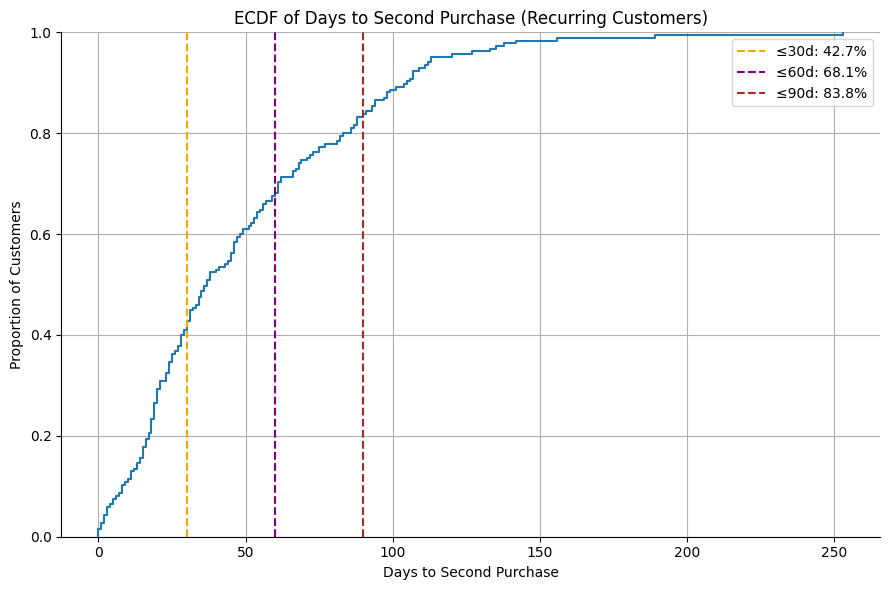

(np.float64(0.42702702702702705),
 np.float64(0.6810810810810811),
 np.float64(0.8378378378378378))

In [43]:
# Calculate cumulative proportions
within_30 = (recurring_repurchase_details["days_to_second"] <= 30).mean()
within_60 = (recurring_repurchase_details["days_to_second"] <= 60).mean()
within_90 = (recurring_repurchase_details["days_to_second"] <= 90).mean()

# Plot ECDF again
sns.displot(
    recurring_repurchase_details,
    x="days_to_second",
    kind="ecdf",
    height=6,
    aspect=1.5
)

# Annotate vertical lines and text for thresholds
plt.axvline(30, color="orange", linestyle="--",
            label=f"≤30d: {within_30*100:.1f}%")
plt.axvline(60, color="purple", linestyle="--",
            label=f"≤60d: {within_60*100:.1f}%")
plt.axvline(90, color="brown", linestyle="--",
            label=f"≤90d: {within_90*100:.1f}%")

plt.legend()
plt.title("ECDF of Days to Second Purchase (Recurring Customers)")
plt.xlabel("Days to Second Purchase")
plt.ylabel("Proportion of Customers")
plt.grid(True)
plt.tight_layout()
plt.show()

within_30, within_60, within_90

In [44]:
# Columns are already in wide format — proceed with analysis directly

# Separate by bundle and discount
bundle_yes = recurring_repurchase_details[recurring_repurchase_details["first_bundle"] == "Yes"]["days_to_second"]
bundle_no = recurring_repurchase_details[recurring_repurchase_details["first_bundle"] == "No"]["days_to_second"]

discounted = recurring_repurchase_details[recurring_repurchase_details["first_discount"] > 0]["days_to_second"]
non_discounted = recurring_repurchase_details[recurring_repurchase_details["first_discount"] == 0]["days_to_second"]

# Calculate mean repurchase timing
bundle_yes.mean(), bundle_no.mean(), discounted.mean(), non_discounted.mean()


(np.float64(46.625),
 np.float64(49.35294117647059),
 np.float64(49.31858407079646),
 np.float64(48.19444444444444))

In [45]:
bundle_yes = recurring_repurchase_details[recurring_repurchase_details["first_bundle"]
                                          == "Yes"]["days_to_second"]
bundle_no = recurring_repurchase_details[recurring_repurchase_details["first_bundle"]
                                         == "No"]["days_to_second"]

# Metrics
bundle_yes = recurring_repurchase_details[recurring_repurchase_details["first_bundle"]
                            == "Yes"]["days_to_second"]
bundle_no = recurring_repurchase_details[recurring_repurchase_details["first_bundle"]
                           == "No"]["days_to_second"]

discounted = recurring_repurchase_details[recurring_repurchase_details["first_discount"]
                            > 0]["days_to_second"]
non_discounted = recurring_repurchase_details[recurring_repurchase_details["first_discount"]
                                == 0]["days_to_second"]

bundle_yes.mean(), bundle_no.mean(), discounted.mean(), non_discounted.mean()

(np.float64(46.625),
 np.float64(49.35294117647059),
 np.float64(49.31858407079646),
 np.float64(48.19444444444444))

For Recurring customers only, here's the refined repurchase analysis:

Bundle buyers repurchase in 46.6 days on average.

Non-bundle buyers repurchase in 49.4 days. → Bundles slightly accelerate repeat purchases.

Discounted first purchases lead to a second purchase in 49.3 days.

Non-discounted purchases lead to repurchase in 48.2 days. → No strong evidence that discounts improve repeat speed for recurring users.

In [46]:
# Create summary table
summary_data = {
    "Customer Segment": ["Bundle Buyers", "Non-Bundle Buyers", "Discounted Buyers", "Non-Discounted Buyers"],
    "Average Days to Second Purchase": [
        bundle_yes.mean(),
        bundle_no.mean(),
        discounted.mean(),
        non_discounted.mean()
    ],
    "Number of Customers": [
        len(bundle_yes),
        len(bundle_no),
        len(discounted),
        len(non_discounted)
    ]
}

summary_table = pd.DataFrame(summary_data)
summary_table

,Customer Segment,Average Days to Second Purchase,Number of Customers
0,Bundle Buyers,46.625000,32
1,Non-Bundle Buyers,49.352941,153
2,Discounted Buyers,49.318584,113
3,Non-Discounted Buyers,48.194444,72


### Q3: Do repeat customers stick to the same products or explore new ones? (e.g., same scents vs. branching out)

In [47]:
# df_order.to_csv('data/df_order.csv', index=False)

In [48]:
df_order.head()

,OrderID,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,Taxes,Total,Discount Code,Discount Amount,Shipping Method,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem compare at price,Lineitem sku,Lineitem requires shipping,Lineitem taxable,Lineitem fulfillment status,Billing Name,Billing Street,Billing Address1,Billing Address2,Billing Company,Billing City,Billing Zip,Billing Province,Billing Country,Billing Phone,Shipping Name,Shipping Street,Shipping Address1,Shipping Address2,Shipping Company,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Shipping Phone,Notes,Note Attributes,Cancelled at,Payment Method,Payment Reference,Refunded Amount,Vendor,Id,Tags,Risk Level,Source,Lineitem discount,Tax 1 Name,Tax 1 Value,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,Duties,Billing Province Name,Shipping Province Name,Payment ID,Payment Terms Name,Next Payment Due At,Payment References,ExcludeTag,Sales Channel,Bundle,CustomerID,Paid at date
0,#1752,troymcdonald1@hotmail.co.uk,paid,2024-01-01 14:25:04,fulfilled,2024-01-03 13:08:52,no,GBP,12.6,2.9,0.0,15.5,BA-06c28a679a8d,1.4,Standard,2024-01-01 14:25:03,1,Apple Pie Candle | Apple + Nutmeg + Cinnamon -...,14.0,0.0,NaN,True,True,fulfilled,Troy McDonald,50 Blackhorse Lane,50 Blackhorse Lane,NaN,NaN,Croydon,CR0 6RS,ENG,GB,NaN,Troy McDonald,50 Blackhorse Lane,50 Blackhorse Lane,NaN,NaN,Croydon,CR0 6RS,ENG,GB,NaN,NaN,bundleData: -\ndiscountName: -\nvariant_ids: -...,NaN,Shopify Payments,c37193584378130.1,0.0,wickguru,5.696814e+12,NaN,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,c37193584378130.1,NaN,NaN,c37193584378130.1,False,Normal,No,1,2024-01-01
1,#1753,senorobe@gmail.com,paid,2024-01-01 18:01:18,fulfilled,2024-01-03 13:08:53,no,GBP,57.5,0.0,0.0,57.5,NaN,0.0,Standard,2024-01-01 18:01:18,1,Build Your Own Candle Bundle - Glass,57.5,78.0,NaN,True,True,fulfilled,Rhys Bailey,44 Crossland Road,44 Crossland Road,NaN,NaN,Blackpool,FY4 4BD,ENG,GB,NaN,Rhys Bailey,44 Crossland Road,44 Crossland Road,NaN,NaN,Blackpool,FY4 4BD,ENG,GB,NaN,NaN,bundleData: -\ndiscountName: -\nvariant_ids: -...,NaN,Shopify Payments,rViYID7WGReHFEKYWQApT59Dm,0.0,Wick Guru,5.696993e+12,NaN,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rViYID7WGReHFEKYWQApT59Dm,NaN,NaN,rViYID7WGReHFEKYWQApT59Dm,False,Normal,No,2,2024-01-01
2,#1754,ashgreylive@gmail.com,paid,2024-01-02 09:33:57,fulfilled,2024-01-03 13:08:54,no,GBP,26.0,2.9,0.0,28.9,NaN,0.0,Standard,2024-01-02 09:33:56,1,Baked Cookies Candle | Butter + Vanilla + Suga...,26.0,0.0,NaN,True,True,fulfilled,Ash Grey,16 Farmington,16 Farmington,NaN,NaN,Farmington,GL54 3NQ,ENG,GB,NaN,Ash Grey,58 High Street,58 High Street,NaN,NaN,Cheltenham,GL50 1EE,ENG,GB,NaN,NaN,"sra_identifiers: {""general"":{},""google_analyti...",NaN,Shopify Payments,rSfGB3VWyRJOoI5iMJGcIs9ei,0.0,wickguru,5.697540e+12,NaN,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rSfGB3VWyRJOoI5iMJGcIs9ei,NaN,NaN,rSfGB3VWyRJOoI5iMJGcIs9ei,False,Normal,No,3,2024-01-02
3,#1755,joseph.speckman@gmail.com,paid,2024-01-02 13:08:43,fulfilled,2024-01-03 13:08:55,no,GBP,14.0,2.9,0.0,16.9,NaN,0.0,Standard,2024-01-02 13:08:42,1,Apple Pie Candle | Apple + Nutmeg + Cinnamon -...,14.0,0.0,NaN,True,True,fulfilled,Joseph Speckman,"2, Oxford Road",2,Oxford Road,NaN,Corby,NN17 2TH,ENG,GB,NaN,Joseph Speckman,"2, Oxford Road",2,Oxford Road,NaN,Corby,NN17 2TH,ENG,GB,NaN,NaN,"sra_identifiers: {""general"":{},""google_analyti...",NaN,Shopify Payments,rkPWKfXE1HqJNMjZBSxTLHSuf,0.0,wickguru,5.697683e+12,NaN,Low,web,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,England,rkPWKfXE1HqJNMjZBSxTLHSuf,NaN,NaN,rkPWKfXE1HqJNMjZBSxTLHSuf,False,Normal,No,4,2024-01-02
4,#1756,gmaloney23@gmail.com,paid,2024-01-02 14:49:57,fulfilled,2024-01-03 13:08:56,no,GBP,26.0,2.9,0.0,28.9,NaN,0.0,Standar

In [49]:
recurring_id = recurring['CustomerID'].unique().tolist()

In [50]:

repeat_customers = df_order[df_order['CustomerID'].isin(recurring_id)]

# For each repeat customer, get the number of unique products they ordered
customer_product_behavior = (
    repeat_customers
    .groupby("CustomerID")["Lineitem name"]
    .agg(["nunique", "count"])
    .rename(columns={"nunique": "unique_products", "count": "total_items"})
)

# Determine behavior: "Same Product(s)" if they ordered only 1 unique product, else "Explored"
customer_product_behavior["behavior"] = customer_product_behavior["unique_products"].apply(
    lambda x: "Same Product(s)" if x == 1 else "Explored"
)

# Summarize counts
behavior_summary = customer_product_behavior["behavior"].value_counts(normalize=True).reset_index()
behavior_summary.columns = ["Behavior", "Proportion"]
behavior_summary["Proportion"] = (behavior_summary["Proportion"] * 100).round(2)

In [51]:
behavior_summary

,Behavior,Proportion
0,Explored,95.68
1,Same Product(s),4.32


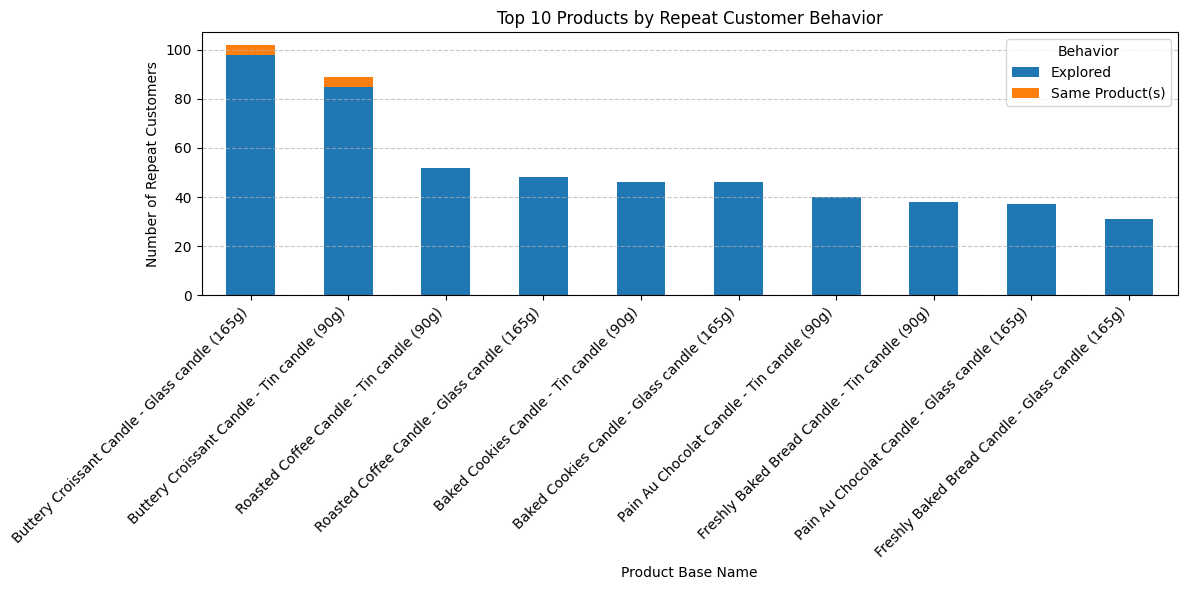

In [52]:
# Join behavior back to repeat_customers to analyze by product
repeat_customers_behavior = repeat_customers.merge(
    customer_product_behavior[["behavior"]],
    on="CustomerID"
)

# Extract a simplified product label from 'Lineitem name' (e.g., remove scent notes or extras)
repeat_customers_behavior["Product Base Name"] = repeat_customers_behavior["Lineitem name"]

# Count behavior type per product base name
product_behavior_summary = (
    repeat_customers_behavior
    .groupby(["Product Base Name", "behavior"])
    .size()
    .unstack(fill_value=0)
    .sort_values("Explored", ascending=False)
)

# Show the top 10 products by number of repeat customers (sum of all behavior types)
top_10_products = (
    product_behavior_summary
    .assign(Total=lambda x: x.sum(axis=1))
    .sort_values("Total", ascending=False)
    .head(10)
    .drop(columns="Total")
)

# Plotting the top 10
top_10_products.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Top 10 Products by Repeat Customer Behavior")
plt.xlabel("Product Base Name")
plt.ylabel("Number of Repeat Customers")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title="Behavior")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Part2: CLTV Analysis


In [53]:
# customer_spending.sort_values('CLTV', ascending=False)

In [54]:
# Sum total spend and number of orders per customer
df_order_paid = df_order[df_order['Financial Status'] == 'paid']
customer_spending = df_order_paid.groupby("CustomerID").agg(
    total_spent=pd.NamedAgg(column="Lineitem price", aggfunc="sum"),
    total_orders=pd.NamedAgg(column="OrderID", aggfunc="nunique"),
    first_order=pd.NamedAgg(column="Paid at", aggfunc="min"),
    last_order=pd.NamedAgg(column="Paid at", aggfunc="max"),
    email=pd.NamedAgg(column="Email", aggfunc="first")
)

# Add derived metrics
customer_spending["days_active"] = (customer_spending["last_order"] - customer_spending["first_order"]).dt.days
customer_spending["order_frequency"] = customer_spending["total_orders"] / (customer_spending["days_active"] + 1)
customer_spending["avg_order_value"] = customer_spending["total_spent"] / customer_spending["total_orders"]
# Tag recurring vs one-time customers
customer_spending["is_repeat"] = customer_spending.index.map(
    lambda x: "Recurring" if x in recurring_id else "One-time"
)
# Estimate CLTV: average order value × order frequency × assumed lifespan (in days)
assumed_lifespan_days_recurring = 90 # 3 months for recurring customers
assumed_lifespan_days_one_time = 1 # 1 day for one-time customers

customer_spending["CLTV"] = customer_spending.apply(
    lambda row: row["avg_order_value"] * row["order_frequency"] *
    (assumed_lifespan_days_recurring if row["is_repeat"]
     == "Recurring" else assumed_lifespan_days_one_time),
    axis=1
)

# Separate repeat vs one-time
repeat_summary = customer_spending.groupby("is_repeat")["CLTV"].agg(["count", "mean", "sum"])

# Format the dataframe to be more human-friendly
repeat_summary_formatted = repeat_summary.copy()
repeat_summary_formatted["mean"] = repeat_summary_formatted["mean"].apply(lambda x: f"${x:,.2f}")
repeat_summary_formatted["sum"] = repeat_summary_formatted["sum"].apply(lambda x: f"${x:,.2f}")
repeat_summary_formatted["count"] = repeat_summary_formatted["count"].apply(lambda x: f"{x:,} customers")

repeat_summary_formatted

,count,mean,sum
is_repeat,,,
One-time,"6,936 customers",$40.77,"$282,776.86"
Recurring,184 customers,$518.34,"$95,374.87"


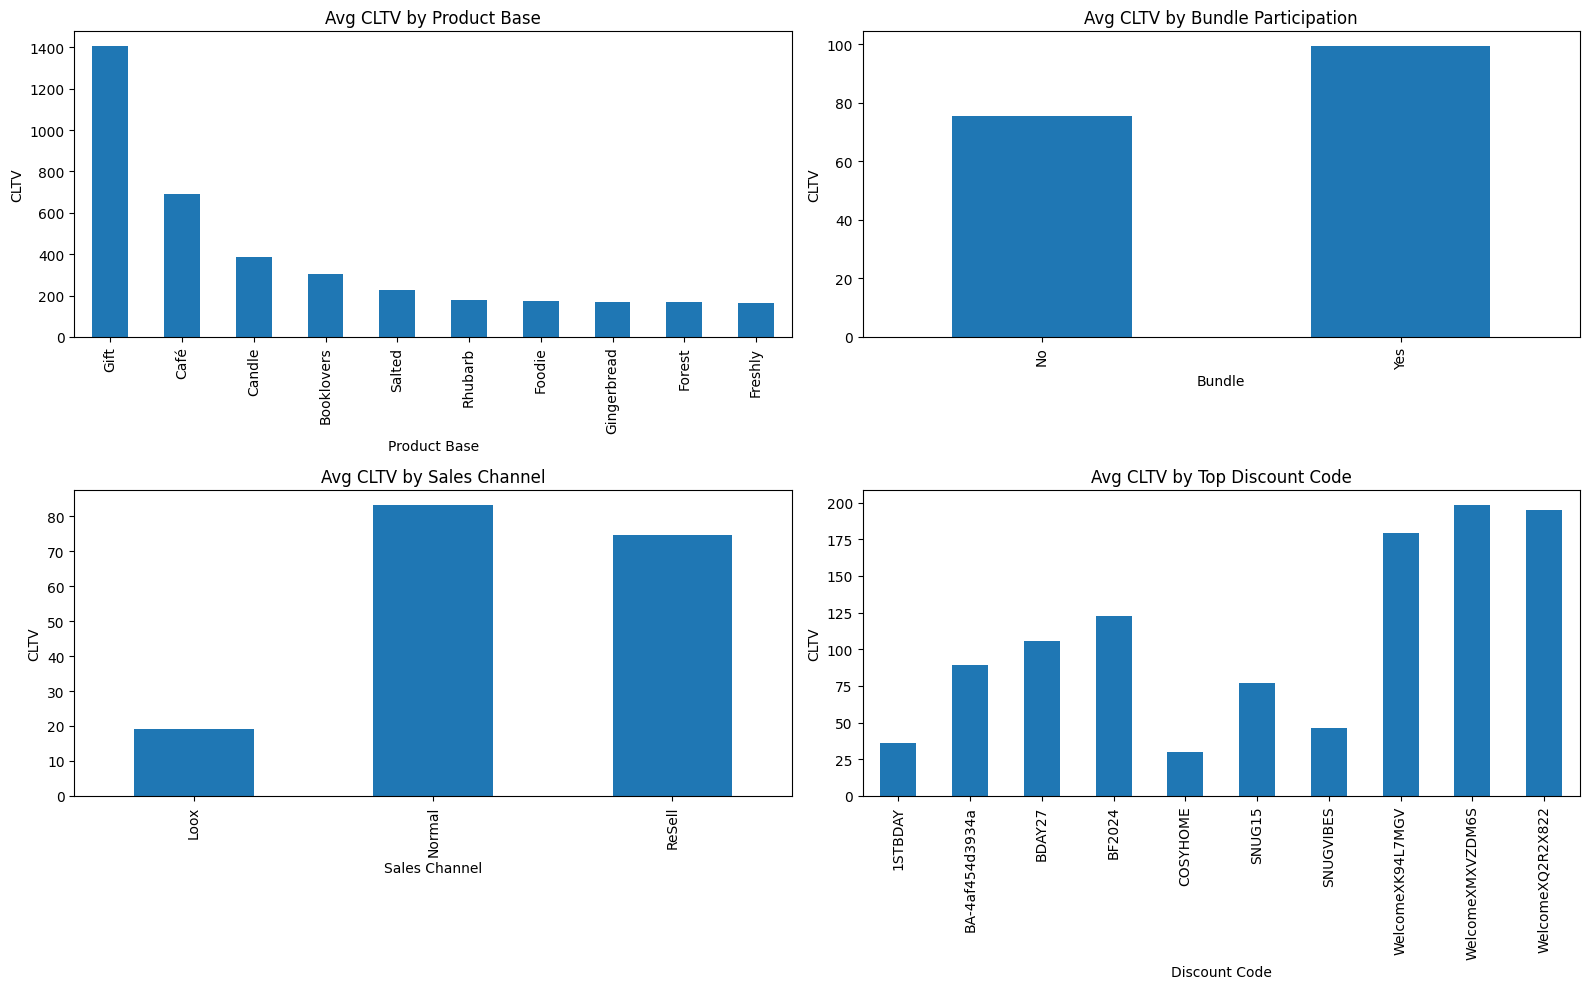

In [55]:
# Merge CLTV data back to the full order data for deeper analysis
df_enriched = df_order.merge(
    customer_spending[["CLTV", "is_repeat", "avg_order_value"]],
    on="CustomerID"
)

# Clean product name and group into product base
df_enriched["Product Base"] = df_enriched["Lineitem name"].str.split(
    " | ").str[0]

# 1. Analyze CLTV by Product Base
cltv_by_product = df_enriched.groupby(
    "Product Base")["CLTV"].mean().sort_values(ascending=False).head(10)

# 2. Analyze CLTV by Bundle participation
cltv_by_bundle = df_enriched.groupby("Bundle")["CLTV"].mean()

# 3. Analyze CLTV by Channel
cltv_by_channel = df_enriched.groupby("Sales Channel")["CLTV"].mean()

# 4. Analyze CLTV by Discount Code Usage (top codes)
top_discount_codes = df_enriched["Discount Code"].value_counts().head(10).index
cltv_by_discount = df_enriched[df_enriched["Discount Code"].isin(
    top_discount_codes)].groupby("Discount Code")["CLTV"].mean()

# Visualize all
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

cltv_by_product.plot(
    kind="bar", ax=axs[0, 0], title="Avg CLTV by Product Base")
axs[0, 0].set_ylabel("CLTV")

cltv_by_bundle.plot(
    kind="bar", ax=axs[0, 1], title="Avg CLTV by Bundle Participation")
axs[0, 1].set_ylabel("CLTV")

cltv_by_channel.plot(
    kind="bar", ax=axs[1, 0], title="Avg CLTV by Sales Channel")
axs[1, 0].set_ylabel("CLTV")

cltv_by_discount.plot(
    kind="bar", ax=axs[1, 1], title="Avg CLTV by Top Discount Code")
axs[1, 1].set_ylabel("CLTV")

plt.tight_layout()
plt.show()

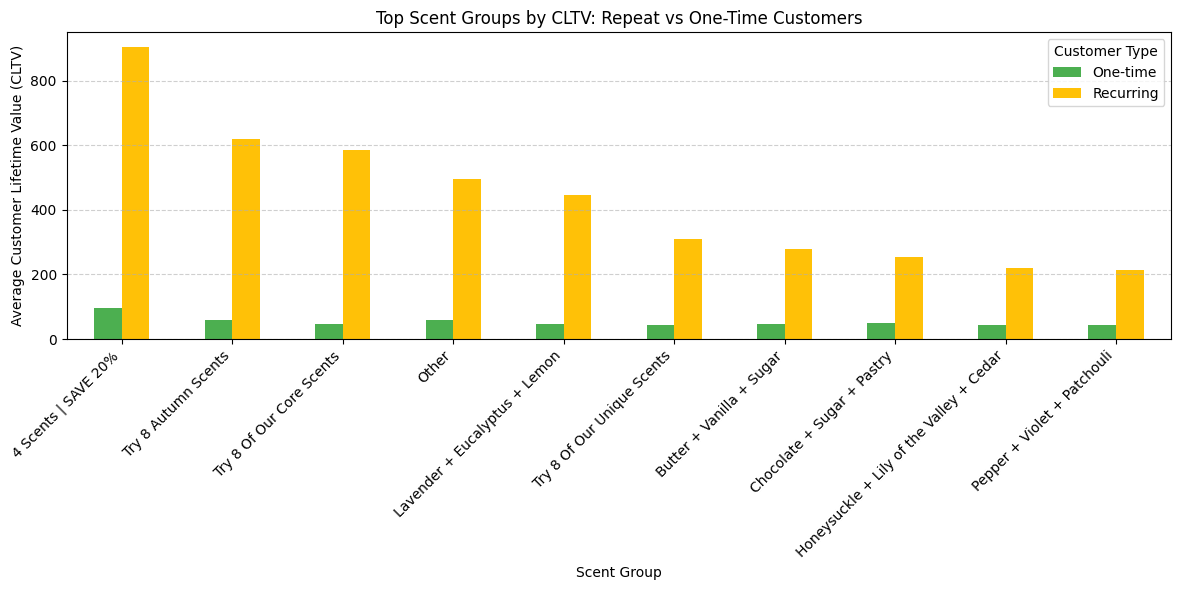

In [64]:
# Extract scent group for segmentation
import re

# Extract scent group


def extract_scent_group(name):
    match = re.search(r'\|\s*(.+)', str(name))
    return match.group(1).split(' -')[0].strip() if match else 'Other'


df_enriched["Scent Group"] = df_enriched["Lineitem name"].apply(extract_scent_group)

# Group by scent group and repeat status
scent_repeat_cltv = (
    df_enriched
    .groupby(["Scent Group", "is_repeat"])["CLTV"]
    .mean()
    .unstack(fill_value=0)
    # .rename(columns={True: "Repeat Customers", False: "One-Time Customers"})
    .sort_values("Recurring", ascending=False)
    .head(10)
)

# Plot
scent_repeat_cltv.plot(kind="bar", figsize=(12, 6),color=["#4CAF50", "#FFC107"])
plt.title("Top Scent Groups by CLTV: Repeat vs One-Time Customers")
plt.xlabel("Scent Group")
plt.ylabel("Average Customer Lifetime Value (CLTV)")
plt.legend(title="Customer Type")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

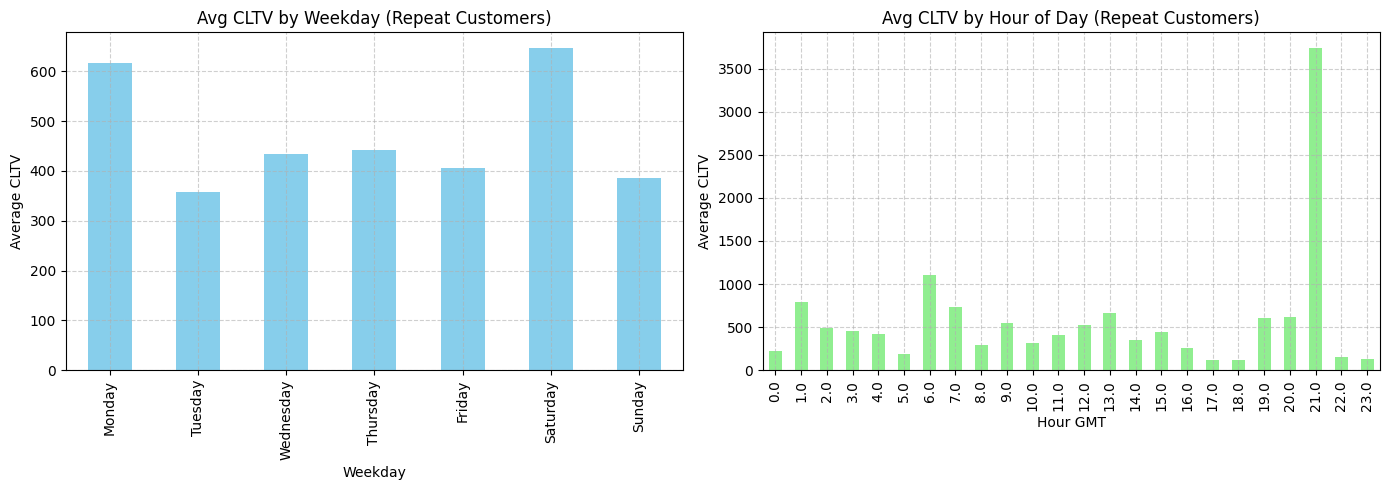

In [75]:
# Ensure datetime conversion again in case it was lost during reset
df_enriched["Paid at"] = pd.to_datetime(
    df_enriched["Paid at"], errors='coerce')

# Recalculate weekday and hour
df_enriched["Weekday"] = df_enriched["Paid at"].dt.day_name()
# Example: convert from UTC+8 to GMT (UTC+0)
df_enriched["Paid at GMT"] = df_enriched["Paid at"].dt.tz_localize(
    "Asia/Singapore", ambiguous='NaT', nonexistent='NaT').dt.tz_convert("GMT")

# Extract hour from GMT time
df_enriched["Hour GMT"] = df_enriched["Paid at GMT"].dt.hour

# Filter repeat customer orders
repeat_orders = df_enriched[df_enriched["is_repeat"] == 'Recurring']

# Handle any missing or invalid datetime values
repeat_orders = repeat_orders.dropna(
    subset=["Paid at", "Weekday", "Hour", "CLTV"])

# Weekday distribution
weekday_order = ["Monday", "Tuesday", "Wednesday",
                 "Thursday", "Friday", "Saturday", "Sunday"]
weekday_cltv = repeat_orders.groupby(
    "Weekday")["CLTV"].mean().reindex(weekday_order)

# Hourly distribution
hour_cltv = repeat_orders.groupby("Hour GMT")["CLTV"].mean()


# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

weekday_cltv.plot(
    kind="bar", ax=axs[0], title="Avg CLTV by Weekday (Repeat Customers)", color='skyblue')
axs[0].set_ylabel("Average CLTV")
axs[0].grid(True, linestyle='--', alpha=0.6)

hour_cltv.plot(
    kind="bar", ax=axs[1], title="Avg CLTV by Hour of Day (Repeat Customers)", color='lightgreen')
axs[1].set_ylabel("Average CLTV")
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
a = df_order[df_order['Financial Status'] == 'paid']

In [ ]:
a['Lineitem price'].sum()

np.float64(336430.03)

In [ ]:
df_order[df_order['OrderID'] == '#5097'].head().T

,5562,5563,5564,5565,5566
OrderID,#5097,#5097,#5097,#5097,#5097
Email,donnamorley1@aol.com,donnamorley1@aol.com,donnamorley1@aol.com,donnamorley1@aol.com,donnamorley1@aol.com
Financial Status,paid,paid,paid,paid,paid
Paid at,2024-08-23 18:10:27,2024-08-23 18:10:27,2024-08-23 18:10:27,2024-08-23 18:10:27,2024-08-23 18:10:27
Fulfillment Status,fulfilled,fulfilled,fulfilled,fulfilled,fulfilled
Fulfilled at,2024-08-30 11:06:06,2024-08-30 11:06:06,2024-08-30 11:06:06,2024-08-30 11:06:06,2024-08-30 11:06:06
Accepts Marketing,yes,yes,yes,yes,yes
Currency,GBP,GBP,GBP,GBP,GBP
Subtotal,286.0,286.0,286.0,286.0,286.0
Shipping,0.0,0.0,0.0,0.0,0.0


In [ ]:
recurring[recurring['CustomerID'] == 137].sort_values(by='Paid at')

,OrderID,Email,CustomerID,Paid at,Fulfilled at,Created at,Cancelled at,Tags,Sales Channel,Bundle,Financial Status,Fulfillment Status,Lineitem quantity,Discount Amount,Total,Customer Type
144,#1896,essieirc@yahoo.com,137,2024-02-02 19:12:12,2024-02-03 12:48:54,2024-02-02 19:12:11,NaN,NaN,Normal,No,paid,fulfilled,2,4.97,44.73,Recurring
417,#2169,essieirc@yahoo.com,137,2024-03-11 01:52:21,2024-03-11 11:25:52,2024-03-11 01:52:21,NaN,NaN,Normal,No,paid,fulfilled,2,7.77,44.03,Recurring
1674,#3427,essieirc@yahoo.com,137,2024-05-17 19:26:10,2024-06-03 14:42:07,2024-05-17 19:26:10,NaN,Simple Bundles - Bundle Order,Normal,Yes,paid,fulfilled,4,14.00,104.80,Recurring
2716,#4516,essieirc@yahoo.com,137,2024-07-21 16:33:38,2024-08-02 15:53:46,2024-07-21 16:31:08,NaN,"ReSell Post-Purchase Upsell, Simple Bundles 2....",ReSell,Yes,paid,fulfilled,7,12.80,94.40,Recurring
3521,#5456,essieirc@yahoo.com,137,2024-09-29 18:55:49,2024-10-02 12:10:20,2024-09-29 18:49:32,NaN,Website,Normal,No,paid,fulfilled,2,18.99,45.00,Recurring
7874,#9851,essieirc@yahoo.com,137,2025-03-14 17:52:31,2025-03-19 09:20:44,2025-03-14 17:52:30,NaN,Simple Bundles 2.0 - Bundle Order,Normal,Yes,paid,fulfilled,4,5.00,54.20,Recurring


In [ ]:
# Calculate the average days between first and second purchase

In [ ]:
# Identify customers with multiple orders on the same day (Paid at shouldn't be null)
valid_orders = agg_orders[agg_orders['Financial Status'] == 'paid']
same_day_orders = valid_orders.groupby(
    ['CustomerID', valid_orders['Created at'].dt.date]).size().reset_index(name='OrderCount')
multiple_orders_same_day = same_day_orders[same_day_orders['OrderCount'] > 1]

print("\nCustomers with multiple orders on the same day:\n",
      multiple_orders_same_day)


Customers with multiple orders on the same day:
       CustomerID  Created at  OrderCount
4              5  2024-01-02           2
88            72  2024-07-21           2
750          645  2024-03-28           2
1691        1488  2024-06-11           2
1772        1561  2024-05-14           2
2157        1900  2024-06-17           2
2329        2046  2024-07-17           2
2510        2211  2024-07-07           2
3240        2892  2024-08-03           2
3843        3473  2024-10-12           2
3903        3530  2024-10-14           2
3908        3534  2024-12-09           2
4240        3865  2024-10-25           2
4977        4584  2024-11-13           2
5692        5279  2024-11-29           2
6038        5627  2024-12-02           2
6074        5661  2025-03-06           2
6216        5802  2024-12-05           2
7097        6684  2024-12-19           2
7296        6877  2025-01-15           2


In [ ]:
multiple_orders_same_day['OrderCount'].sum()

np.int64(40)

In [ ]:
agg_orders[agg_orders['CustomerID'] == 3698]

,OrderID,Email,CustomerID,Paid at,Fulfilled at,Created at,Cancelled at,Tags,Sales Channel,Bundle,Financial Status,Fulfillment Status,Lineitem quantity,Discount Amount,Total,Customer Type,First Purchase No Bundle
3998,#5945,emmacrampton97@gmail.com,3698,2024-10-20 17:33:39,2024-10-22 16:14:15,2024-10-20 17:33:39,NaN,NaN,Normal,No,paid,fulfilled,1,9.6,86.4,One-time,False


In [ ]:

# Calculate Recency, Frequency, Monetary (RFM) values
rfm = df.groupby('CustomerID').agg({
    'Paid at': lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days,
    'OrderID': 'count',
    'Total': 'sum'
}).rename(columns={
    'Paid at': 'Recency',
    'OrderID': 'Frequency',
    'Total': 'Monetary'
})

In [ ]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
1,451.0,1,15.50
2,451.0,1,57.50
3,450.0,1,28.90
4,450.0,1,16.90
5,450.0,2,57.80
...,...,...,...
7321,2.0,1,51.20
7322,2.0,6,518.40
7323,2.0,3,258.00
